<a href="https://colab.research.google.com/github/namirinz/YSC21-AI_KME/blob/master/Image_Captioning/KME_Image_captioning_bahdanau.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import Library

In [1]:
!pip install nami --upgrade
!rm -rf .keras

Requirement already up-to-date: nami in /usr/local/lib/python3.6/dist-packages (1.2.1.12)


In [2]:
import nami
import time
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

In [3]:
!nvidia-smi

Mon Nov 16 12:01:31 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 455.32.00    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P0    39W / 300W |    445MiB / 16130MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Import Dataset

In [4]:
from nami.datasets.kme import load_data
(image_train, caption_train), (image_test, caption_test) = load_data()
print(image_train.shape, caption_train.shape)
print(image_test.shape, caption_test.shape)

(545, 224, 224, 3) (545,)
(137, 224, 224, 3) (137,)


## Preprocessing Dataset

In [5]:
from nami.AI.kme_tokenize import Tokenizer
tokenizer = Tokenizer()

In [6]:
tokenizer.fit_on_texts(caption_train)

In [7]:
text2seq_train = tokenizer.text_to_sequences(caption_train)
seq2text_train = tokenizer.sequences_to_text(text2seq_train)

In [8]:
text2seq_test = tokenizer.text_to_sequences(caption_test)
seq2text_test = tokenizer.sequences_to_text(text2seq_test)

In [9]:
text2seq_train.shape

(545, 32)

## Hyperparameter

In [10]:
BATCH_SIZE = 32
BUFFER_SIZE = 1000
units = 512
vocab_size = len(tokenizer.word2index)

num_steps_train = len(image_train) // BATCH_SIZE
num_steps_test = len(image_test) // BATCH_SIZE

max_length_train = text2seq_train.shape[1]
max_length_test = text2seq_test.shape[1]

encoding_size = 256 # Determines dimension of the encodings of images

## tf.data.Dataset

In [11]:
import random
from tensorflow.keras.preprocessing.image import random_rotation, random_channel_shift

def rescale_fn(image, label):
  image = tf.cast(image, tf.float32)
  return tf.keras.applications.xception.preprocess_input(image), tf.cast(label, tf.float32)

def prob_fn():
  prob = np.random.uniform(size=1)
  return prob[0]

def augment_fn(image, label):
  image, label = rescale_fn(image, label)
  image = tf.image.random_flip_left_right(image)
  image = tf.image.random_flip_up_down(image)
  image = tf.image.rot90(image, tf.random.uniform(shape=[], minval=0, maxval=4, dtype=tf.int32))
  
  # Add some noise
  gnoise = tf.random.normal(shape=tf.shape(image), mean=0.0, stddev=0.11, dtype=tf.float32)
  image = tf.add(image, gnoise)
  
  return image, tf.cast(label, tf.float32)

In [12]:
with tf.device('/cpu:0'):
  dataset = tf.data.Dataset.from_tensor_slices((image_train, text2seq_train)).map(
      augment_fn, num_parallel_calls = tf.data.experimental.AUTOTUNE
  ).shuffle(
    len(image_train)
  ).repeat(2).batch(
      BATCH_SIZE, drop_remainder = True
  ).cache(      
  ).prefetch(
      tf.data.experimental.AUTOTUNE
)

In [13]:
with tf.device('/cpu:0'):
  dataset_val = tf.data.Dataset.from_tensor_slices((image_test, text2seq_test)).map(
      rescale_fn, num_parallel_calls = tf.data.experimental.AUTOTUNE
  ).shuffle(
    len(image_test)
  ).batch(
      BATCH_SIZE, drop_remainder = True
  ).cache(      
  ).prefetch(
      tf.data.experimental.AUTOTUNE
)


# Model Architecture

## EfficientNetB7 

In [14]:
from tensorflow.keras.applications import xception

pret_model = xception.Xception(include_top = False, weights='imagenet', input_shape=(224, 224, 3))
# Output shape = [batch_size, 7, 7, 2560]

In [15]:
pret_model.summary()

Model: "xception"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 111, 111, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 111, 111, 32) 128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 111, 111, 32) 0           block1_conv1_bn[0][0]            
___________________________________________________________________________________________

## CNN Encoder (Encoder output of feature extraction)

In [16]:
from tensorflow.keras.models import Sequential
encoder = Sequential([
    pret_model,
    #tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(encoding_size,activation='relu',name="encoding_layer"),
    tf.keras.layers.Reshape(target_shape=(7 * 7, encoding_size))
], name= "CNN_feature_extraction")

In [17]:
encoder.summary()

Model: "CNN_feature_extraction"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
xception (Functional)        (None, 7, 7, 2048)        20861480  
_________________________________________________________________
encoding_layer (Dense)       (None, 7, 7, 256)         524544    
_________________________________________________________________
reshape (Reshape)            (None, 49, 256)           0         
Total params: 21,386,024
Trainable params: 21,331,496
Non-trainable params: 54,528
_________________________________________________________________


## Bahdanau Attention (Class)

In [18]:
from tensorflow.keras.layers import Dense, Embedding, GRU

In [19]:
def create_attention(features, hidden):
  # features(CNN_encoder output) shape == (batch_size, 25, embedding_dim)
  # hidden shape == (batch_size, hidden_size)
  
  # hidden_with_time_axis shape == (batch_size, 1, hidden_size)
  hidden_with_time_axis = tf.expand_dims(hidden, 1)

  # attention_hidden_layer shape == (batch_size, 25, units)
  attention_hidden_layer = tf.nn.tanh( Dense(units)(features) + Dense(units)(hidden_with_time_axis) )
  
  # score shape == (batch_size, 25, 1)
  # This gives you an unnormalized score for each image feature.
  score = tf.keras.layers.Dense(1)(attention_hidden_layer)

    # attention_weights shape == (batch_size, 25, 1)
  attention_weights = tf.nn.softmax(score, axis=1)

  # context_vector shape after sum == (batch_size, hidden_size)
  context_vector = attention_weights * features
  context_vector = tf.reduce_sum(context_vector, axis=1)

  return context_vector, attention_weights

In [20]:
def create_decoder():
  features = tf.keras.layers.Input((49, 256))
  dec_input= tf.keras.layers.Input((1))
  hidden = tf.keras.layers.Input((units))

  context_vector, attention_weights = create_attention(features, hidden)
  
  # x shape after passing through embedding == (batch_size, 1, encoding_size) 
  x = Embedding(vocab_size, encoding_size)(dec_input)
  
  # x shape after concatenation == (batch_size, 1, encoding_size + hidden_size)
  x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)

  output, state = GRU(units,return_sequences=True,return_state=True,recurrent_initializer='glorot_uniform')(x, initial_state=[hidden])
  
  # shape == (batch_size, max_length, hidden_size)
  x = Dense(units)(output)

  # x shape == (batch_size * max_length, hidden_size)
  x = tf.reshape(x, (-1, x.shape[2]))

  output = Dense(vocab_size)(x)

  return tf.keras.models.Model([features, dec_input, hidden], [output, state, attention_weights])

def reset_state(batch_size):
  return tf.zeros((batch_size, units))

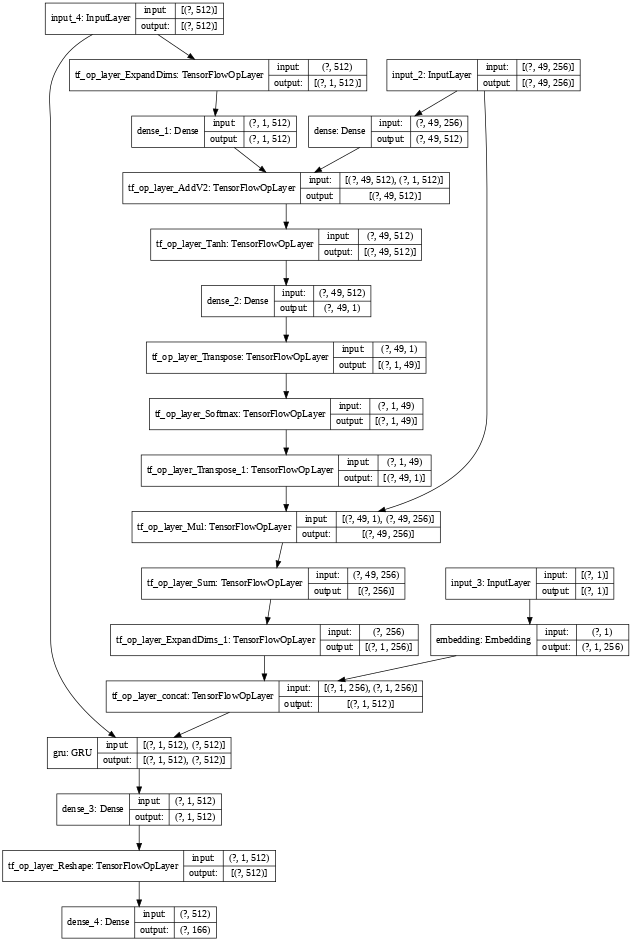

In [21]:
decoder = create_decoder()
tf.keras.utils.plot_model(decoder, show_shapes=True, dpi = 49)

In [22]:
"""
class BahdanauAttention(tf.keras.Model):
  def __init__(self, units):
    super(BahdanauAttention, self).__init__()
    self.W1 = tf.keras.layers.Dense(units)
    self.W2 = tf.keras.layers.Dense(units)
    self.V = tf.keras.layers.Dense(1)

  def call(self, features, hidden):
    # features(CNN_encoder output) shape == (batch_size, 25, embedding_dim)

    # hidden shape == (batch_size, hidden_size)
    # hidden_with_time_axis shape == (batch_size, 1, hidden_size)
    hidden_with_time_axis = tf.expand_dims(hidden, 1)

    # attention_hidden_layer shape == (batch_size, 25, units)
    attention_hidden_layer = (tf.nn.tanh(self.W1(features) +
                                         self.W2(hidden_with_time_axis)))

    # score shape == (batch_size, 25, 1)
    # This gives you an unnormalized score for each image feature.
    score = self.V(attention_hidden_layer)

    # attention_weights shape == (batch_size, 25, 1)
    attention_weights = tf.nn.softmax(score, axis=1)

    # context_vector shape after sum == (batch_size, hidden_size)
    context_vector = attention_weights * features
    context_vector = tf.reduce_sum(context_vector, axis=1)

    return context_vector, attention_weights
"""

'\nclass BahdanauAttention(tf.keras.Model):\n  def __init__(self, units):\n    super(BahdanauAttention, self).__init__()\n    self.W1 = tf.keras.layers.Dense(units)\n    self.W2 = tf.keras.layers.Dense(units)\n    self.V = tf.keras.layers.Dense(1)\n\n  def call(self, features, hidden):\n    # features(CNN_encoder output) shape == (batch_size, 25, embedding_dim)\n\n    # hidden shape == (batch_size, hidden_size)\n    # hidden_with_time_axis shape == (batch_size, 1, hidden_size)\n    hidden_with_time_axis = tf.expand_dims(hidden, 1)\n\n    # attention_hidden_layer shape == (batch_size, 25, units)\n    attention_hidden_layer = (tf.nn.tanh(self.W1(features) +\n                                         self.W2(hidden_with_time_axis)))\n\n    # score shape == (batch_size, 25, 1)\n    # This gives you an unnormalized score for each image feature.\n    score = self.V(attention_hidden_layer)\n\n    # attention_weights shape == (batch_size, 25, 1)\n    attention_weights = tf.nn.softmax(score, axi

## RNN Decoder (Class)


In [23]:
"""
class RNN_Decoder(tf.keras.Model):
  def __init__(self, encoding_size, units, vocab_size):
    super(RNN_Decoder, self).__init__()
    self.units = units

    self.embedding = tf.keras.layers.Embedding(vocab_size, encoding_size)
    self.gru = tf.keras.layers.GRU(self.units,
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform')
    self.fc1 = tf.keras.layers.Dense(self.units)
    self.fc2 = tf.keras.layers.Dense(vocab_size)

    self.attention = BahdanauAttention(self.units)

  def __call__(self,features, x, hidden):
    # defining attention as a separate model
    context_vector, attention_weights = self.attention(features, hidden)

    # x shape after passing through embedding == (batch_size, 1, encoding_size)
    x = self.embedding(x)

    # x shape after concatenation == (batch_size, 1, encoding_size + hidden_size)
    x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)

    # passing the concatenated vector to the GRU
    output, state = self.gru(x, initial_state=[hidden])

    # shape == (batch_size, max_length, hidden_size)
    x = self.fc1(output)

    # x shape == (batch_size * max_length, hidden_size)
    x = tf.reshape(x, (-1, x.shape[2]))

    # output shape == (batch_size * max_length, vocab)
    x = self.fc2(x)

    return x, state, attention_weights

  def reset_state(self, batch_size):
    return tf.zeros((batch_size, self.units))
"""

"\nclass RNN_Decoder(tf.keras.Model):\n  def __init__(self, encoding_size, units, vocab_size):\n    super(RNN_Decoder, self).__init__()\n    self.units = units\n\n    self.embedding = tf.keras.layers.Embedding(vocab_size, encoding_size)\n    self.gru = tf.keras.layers.GRU(self.units,\n                                   return_sequences=True,\n                                   return_state=True,\n                                   recurrent_initializer='glorot_uniform')\n    self.fc1 = tf.keras.layers.Dense(self.units)\n    self.fc2 = tf.keras.layers.Dense(vocab_size)\n\n    self.attention = BahdanauAttention(self.units)\n\n  def __call__(self,features, x, hidden):\n    # defining attention as a separate model\n    context_vector, attention_weights = self.attention(features, hidden)\n\n    # x shape after passing through embedding == (batch_size, 1, encoding_size)\n    x = self.embedding(x)\n\n    # x shape after concatenation == (batch_size, 1, encoding_size + hidden_size)\n    x = tf

In [24]:
#decoder = RNN_Decoder(encoding_size = encoding_size, units = units, vocab_size = vocab_size)

In [25]:
#model =  ImageBahda(encoder = encoder, decoder = decoder)

# Custom Loss Function


In [26]:
from tensorflow.keras.optimizers import Adam, Nadam

opt = Adam(learning_rate=0.0003)

In [27]:
def loss_fn(real, pred):
  # Word Loss

  real_onehot = tf.one_hot(tf.cast(real, tf.uint8), vocab_size)

  loss_object = tf.keras.losses.CategoricalCrossentropy(from_logits=True, reduction = 'none', label_smoothing=0.2)
  mask = tf.math.logical_not(tf.math.equal(real, 0))
  loss_ = loss_object(real_onehot, pred)

  mask = tf.cast(mask, dtype=loss_.dtype)
  loss_ *= mask

  # EOS Loss
  loss_object2 = tf.keras.losses.BinaryCrossentropy(from_logits=True, label_smoothing=0.2)

  end_token = tokenizer.word2index['<end>']
  pred_id = tf.math.argmax(pred, axis=-1)

  real_eos = tf.cast(tf.math.equal(real, end_token), dtype=tf.float32)
  pred_eos = tf.cast(tf.math.equal(pred_id, end_token), dtype=tf.float32)

  loss_2 = loss_object2(real_eos, pred_eos)

  return tf.reduce_mean(loss_) + loss_2 

# Metrics

In [28]:
train_acc = tf.keras.metrics.SparseCategoricalAccuracy(name='train_accuracy')
val_acc = tf.keras.metrics.SparseCategoricalAccuracy(name='val_accuracy')

# Sub Class Model

In [29]:
class ImageBahda(tf.keras.Model):
  def __init__(self, encoder, decoder, max_length_train, max_length_test):
    super().__init__()
    self.encoder = encoder
    self.decoder = decoder
    self.hidden_state = None
    self.decoder_input = None
    self.max_length_train = max_length_train
    self.max_length_test = max_length_test
    self.total_loss = 0.0

  def compile(self, loss_fn, opt, metrics):
    super().compile()
    self.loss_fn = loss_fn
    self.opt = opt
    self.train_acc, self.val_acc = metrics


  def train_step(self, input):
    img_tensor, target = input
    batch_size = BATCH_SIZE
    #print(tf.shape(img_tensor))
    self.hidden_state = reset_state(batch_size = batch_size)
    self.decoder_input = tf.expand_dims([tokenizer.word2index['<start>']] * batch_size, 1)
    loss = 0
  
    with tf.GradientTape() as tape:
      img_feature = self.encoder(img_tensor)
      
      for i in range(1, target.shape[1]):
        # passing the features through the decoder
        predictions, self.hidden_state, _ = self.decoder([img_feature, self.decoder_input, self.hidden_state])
        loss += self.loss_fn(target[:,i], predictions)
        # using teacher forcing
        self.decoder_input = tf.expand_dims(target[:, i], 1)
        # Metrics
        self.train_acc.update_state(target[:, i], predictions)

    gradient = tape.gradient(loss, self.encoder.trainable_variables + self.decoder.trainable_variables) 
    self.opt.apply_gradients(zip(gradient, self.encoder.trainable_variables + self.decoder.trainable_variables))
    
    return {'loss': loss / target.shape[1], 'acc' : self.train_acc.result()}

  def test_step(self, input):
    img_tensor, target = input
    batch_size = BATCH_SIZE
    #print(batch_size)

    self.hidden_state = reset_state(batch_size = batch_size)
    self.decoder_input = tf.expand_dims([tokenizer.word2index['<start>']] * batch_size, 1)
    loss = 0

    with tf.GradientTape() as tape:  
      img_feature = self.encoder(img_tensor)

      for i in range(1, self.max_length_test):
        predictions, self.hidden_state, _ = decoder([img_feature, self.decoder_input, self.hidden_state])
        loss += self.loss_fn(target[:,i], predictions)
          
        self.decoder_input = tf.expand_dims(target[:, i], 1)

        self.val_acc.update_state(target[:, i], predictions)

    return {'loss': loss/self.max_length_test, 'acc': self.val_acc.result()}

  @property
  def metrics(self):
    return [self.train_acc, self.val_acc]

In [30]:
Model = ImageBahda(
    encoder = encoder, decoder = decoder,
    max_length_train = max_length_train, max_length_test = max_length_test
)

In [31]:
Model.compile(
    loss_fn = loss_fn,
    opt = opt,
    metrics = [train_acc, val_acc]
)

In [32]:
checkpoint = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience = 5, restore_best_weights=True, mode='min')
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=2, verbose=1)

callback_list = [checkpoint, reduce_lr]

In [33]:
Model.fit(dataset, validation_data = (dataset_val), epochs = 50, callbacks=callback_list)

Epoch 1/50
34/34 [==============================] - 25s 746ms/step - loss: 2.1702 - acc: 0.0737 - val_loss: 2.1491 - val_acc: 0.0848
Epoch 2/50
34/34 [==============================] - 11s 327ms/step - loss: 2.1624 - acc: 0.0962 - val_loss: 2.0660 - val_acc: 0.1266
Epoch 3/50
34/34 [==============================] - 11s 327ms/step - loss: 1.9996 - acc: 0.1537 - val_loss: 1.7417 - val_acc: 0.1549
Epoch 4/50
34/34 [==============================] - 11s 327ms/step - loss: 1.8198 - acc: 0.1860 - val_loss: 1.6667 - val_acc: 0.1652
Epoch 5/50
34/34 [==============================] - 11s 328ms/step - loss: 1.7065 - acc: 0.2066 - val_loss: 1.6518 - val_acc: 0.1751
Epoch 6/50
34/34 [==============================] - 11s 328ms/step - loss: 1.6004 - acc: 0.2191 - val_loss: 1.6096 - val_acc: 0.1744
Epoch 7/50
34/34 [==============================] - 11s 325ms/step - loss: 1.5668 - acc: 0.2307 - val_loss: 1.6182 - val_acc: 0.1953
Epoch 8/50
34/34 [==============================] - ETA: 0s - loss: 1

In [34]:
Model.encoder.save('encoder_model.h5', include_optimizer=False)
Model.decoder.save('decoder_model.h5', include_optimizer=False)

encoder = tf.keras.models.load_model('encoder_model.h5')
decoder = tf.keras.models.load_model('decoder_model.h5')

In [35]:
img = tf.keras.applications.xception.preprocess_input(image_test[0])
print(np.min(img), np.max(img))

-0.5686275 1.0


# Caption It

In [36]:
attention_features_shape = 49
features_shape = 2560
max_test_length = max
def evaluate(image, max_length):
    attention_plot = np.zeros((max_length, attention_features_shape))

    hidden_state = reset_state(batch_size = 1)

    image = tf.reshape(image, shape=(1,image.shape[0],image.shape[1],image.shape[2]))
    image = tf.keras.applications.xception.preprocess_input( tf.cast(image, tf.float32) )
    features = encoder( image )

    dec_input = tf.expand_dims([tokenizer.word2index['<start>']], 0)
    result = []

    for i in range(max_length): # *

        predictions, hidden_state, attention_weights = decoder([features, dec_input, hidden_state])

        attention_plot[i] = tf.reshape(attention_weights, (-1, )).numpy()

        predicted_id = np.argmax(predictions, axis=-1)[0]

        result.append(tokenizer.index2word[predicted_id])

        if tokenizer.index2word[predicted_id] == '<end>':
            return result, attention_plot

        dec_input = tf.expand_dims([predicted_id], 0)

    attention_plot = attention_plot[:len(result), :]
    return result, attention_plot

In [37]:
def plot_attention(image, result, attention_plot):

    fig = plt.figure(figsize=(10, 10))
    fig.suptitle(''.join(result[:-1]), fontsize=22, y = 1.03)
    len_result = len(result)
    for l in range(len_result):
        temp_att = np.resize(attention_plot[l], (8, 8))
        ax = fig.add_subplot(len_result//2, len_result//2, l+1)
        ax.set_title(result[l])
        img = ax.imshow(image)
        ax.imshow(temp_att, cmap='gray', alpha=0.6, extent=img.get_extent())
    
    plt.tight_layout()
    plt.show()

Real Caption: octa-2,4-diene
Prediction Caption: hepta-2,4-diene


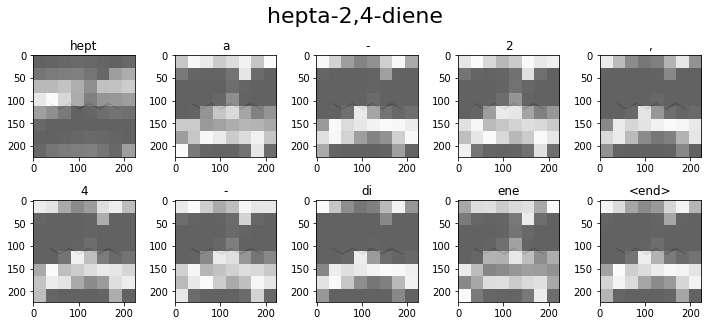

In [50]:
# captions on the validation set
result, attention_plot = evaluate(image_test[55], max_length_test)

print ('Real Caption:', caption_test[55])
print ('Prediction Caption:', ''.join(result[:-1]))

plot_attention(image_test[55], result, attention_plot)

In [39]:
import nltk
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction

In [40]:
from nami.AI.kme_tokenize import Segmentation
kme_segment = Segmentation()

In [41]:
best_score = {}
chencherry = SmoothingFunction()
from tqdm.notebook import trange
for i in trange(len(image_test)):
  word_arr, _ = evaluate(image_test[i], max_length_test)
  real_word,_ = kme_segment.word_segmentation(caption_test[i])

  score = sentence_bleu([real_word], word_arr[:-1], smoothing_function = chencherry.method4)
  best_score[i] = score
  #print(f"{i} | {score:.4f}", end=' ')
  #print(''.join(word_arr[:-1]), end=' : ')
  #print(caption_test[i])

In [42]:
sort_best_score = sorted(best_score.items(), key=lambda x: x[1], reverse=True)

# BLEU SCORE

In [43]:
for i in range(100):
  print(sort_best_score[i][0], sort_best_score[i][1])

55 0.8633400213704505
119 0.8633400213704505
108 0.6606328636027614
46 0.6032482383565995
80 0.5969491792019646
130 0.570282226440554
26 0.4548019047027907
12 0.43167001068522526
13 0.43167001068522526
110 0.43167001068522526
112 0.43167001068522526
125 0.43167001068522526
28 0.42818185319516083
0 0.393884992777205
129 0.3934995962231127
11 0.392814650900513
53 0.392814650900513
61 0.3893181523576895
134 0.38498150077635496
54 0.38095304346290776
67 0.3807134866446316
10 0.360056585428503
115 0.360056585428503
48 0.3549481056010053
88 0.3521998780372244
101 0.34846944887433073
4 0.3310878611259884
18 0.3258798048281462
7 0.3206576286528781
102 0.31569611706824424
92 0.31312356650271234
97 0.31312356650271234
103 0.31312356650271234
128 0.31312356650271234
132 0.30483335667394
123 0.301164459337964
21 0.28807456767504735
23 0.28684188448849735
25 0.28684188448849735
39 0.28684188448849735
75 0.28684188448849735
79 0.28684188448849735
113 0.28684188448849735
133 0.28684188448849735
118 0

deca-4,6-diene


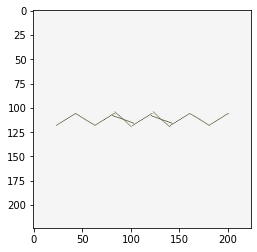

In [44]:
print(caption_test[0])
plt.imshow(image_test[0])

Real Caption: N-(2-hydroxyethyl)dodecanamide
Prediction Caption: hexanamide


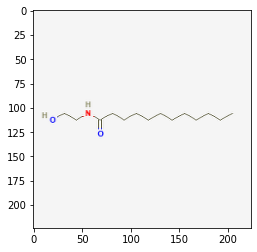

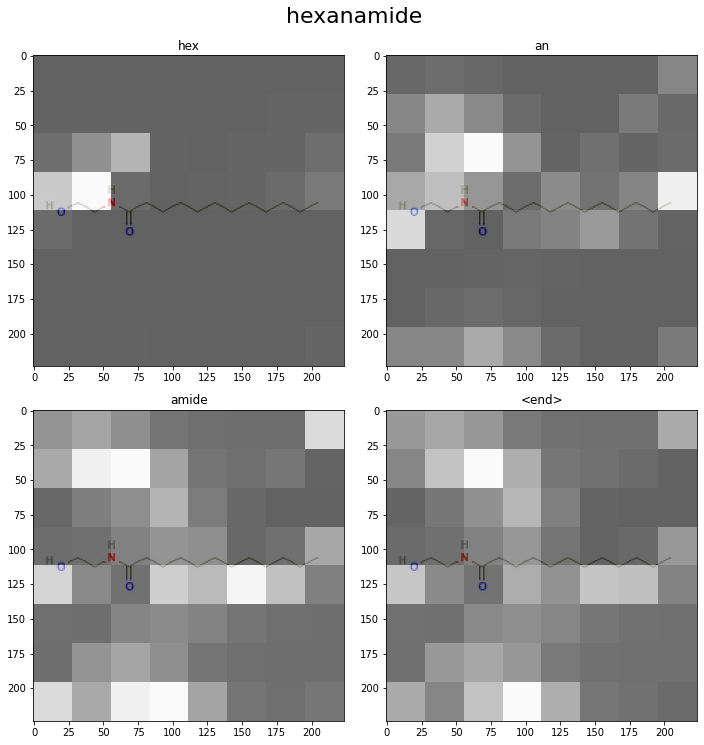

In [45]:
# captions on the validation set
result, attention_plot = evaluate(image_test[19], max_length_test)

print ('Real Caption:', caption_test[19])
print ('Prediction Caption:', ''.join(result[:-1]))
plt.imshow(image_test[19])
plt.show()
plot_attention(image_test[19], result, attention_plot)


Real Caption: nona-1,3-diene
Prediction Caption: octa-2,4-diene


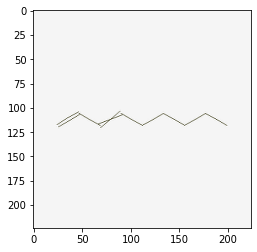

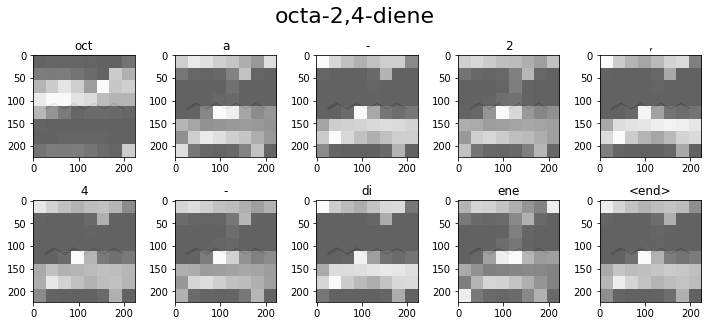

In [46]:
# captions on the validation set
result, attention_plot = evaluate(image_test[25], max_length_test)

print ('Real Caption:', caption_test[25])
print ('Prediction Caption:', ''.join(result[:-1]))
plt.imshow(image_test[25])
plt.show()
plot_attention(image_test[25], result, attention_plot)


Real Caption: 2,3-dihydro-1,4-benzodioxine-3-carboxylic acid
Prediction Caption: 2-methyl-4-methyl-4-methyl-1,4-benzodioxine


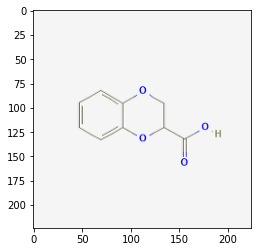

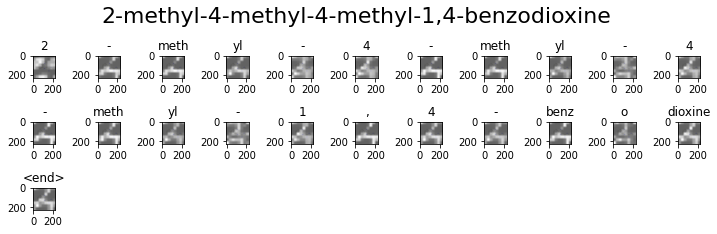

In [47]:
# captions on the validation set
result, attention_plot = evaluate(image_train[98], max_length_train)

print ('Real Caption:', caption_train[98])
print ('Prediction Caption:', ''.join(result[:-1]))
plt.imshow(image_train[98])
plt.show()
plot_attention(image_train[98], result, attention_plot)


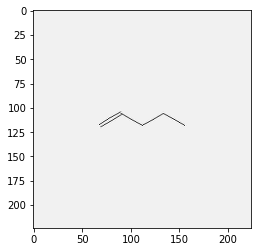

In [48]:
plt.imshow(image_train[0,:,:,0], cmap='gray')

Real Caption: cycloheptene
Prediction Caption: benzene


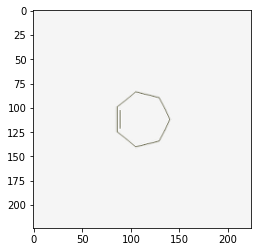

ValueError: ignored

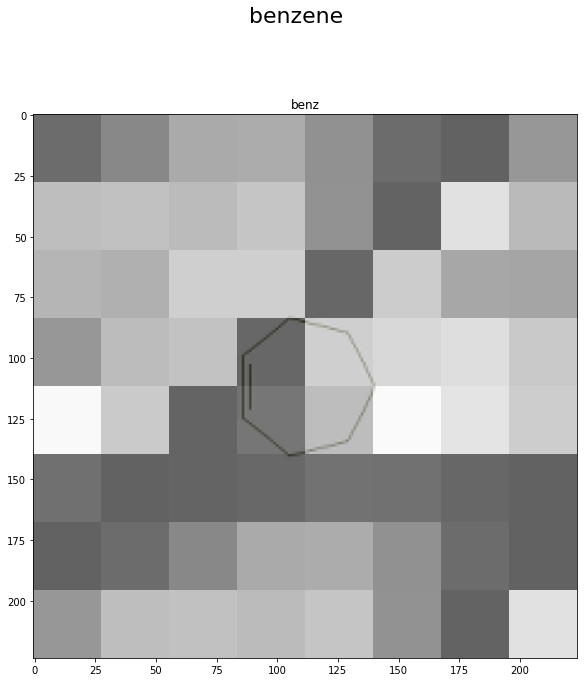

In [49]:
# captions on the validation set
result, attention_plot = evaluate(image_test[100], max_length_test)

print ('Real Caption:', caption_test[100])
print ('Prediction Caption:', ''.join(result[:-1]))
plt.imshow(image_test[100])
plt.show()
plot_attention(image_test[100], result, attention_plot)
